# Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.contingency_tables import StratifiedTable
import os
from scipy import stats

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df_serp=pd.read_csv('Downloads\serps.csv')
df_metrics=pd.read_csv('Downloads\metrics.csv')

In [36]:
df_serp["vacancy_id_conv"].nunique()

55500

In [3]:
df_m=df_serp.merge(df_metrics)
df_m.head()

,request_id,vacancy_id_conv,city,applicant,metric_full,emplpyer_id
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076,3.869807,4815
1,1687196322554b091cf99ec5fd0949d0,48019,Moscow,379829,3.869807,4815
2,168718801728012110e723f6e5763351,48019,Moscow,379144,3.869807,4815
3,1687195028379296aef0c3bce4c606d1,48019,Moscow,284223,3.869807,4815
4,1687182857283108ba3c1249550a66fe,48019,Moscow,460779,3.869807,4815


## Группировка данных

Соискатели и количество городов, в которых они ищут вакансии

In [25]:
df_appl=df_m.groupby('applicant').agg({"city":"count"}).reset_index()

По результатам выдачи

In [99]:
df_gserp=df_m.groupby('request_id').agg(totals=('request_id','count'),max_scor=('metric_full','max'),\
                                            min_scor=('metric_full','min')\
                               ).reset_index()

По работодателям

In [109]:
df_empl=df_metrics.groupby('emplpyer_id').agg(totals=('vacancy_id_conv','count'),max_scor=('metric_full','max'),\
                                            min_scor=('metric_full','min')\
                               ).reset_index()

## Анализ полученных данных

### Соискатели

Количество уникальных соскателей

In [22]:
df_appl.shape[0]

911862

Медиана количества городов, в котором один соискатель ищет работу

In [24]:
df_appl['city'].median()

2.0

Насколько много людей ищет работу в нескольких городах

In [28]:
round(100*df_appl.query("city > 1").shape[0]/df_appl.shape[0],1)

76.6

### Вакансии

Доля вакансий со скор < 3

In [92]:
round(100*df_metrics.query("metric_full<3").shape[0]/df_metrics.shape[0], 2)

15.31

### SERP

Количество вакансий на странице выдачи

In [104]:
df_gserp.totals.describe()

count    1000000.000000
mean           2.431596
std            2.290122
min            1.000000
25%            1.000000
50%            2.000000
75%            3.000000
max           50.000000
Name: totals, dtype: float64

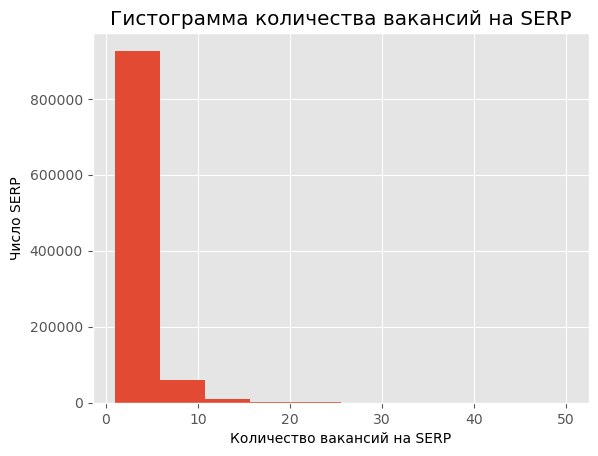

In [106]:
plt.hist(df_gserp.totals)
plt.xlabel("Количество вакансий на SERP")
plt.ylabel("Число SERP")
plt.title("Гистограмма количества вакансий на SERP")
plt.show()

In [107]:
df_gserp.totals.median()

2.0

### Работодатели

In [110]:
df_empl.head()

,emplpyer_id,totals,max_scor,min_scor
0,0,3,3.519367,2.415642
1,1,9,6.336716,1.764291
2,2,6,5.045708,2.634967
3,3,6,6.277994,1.710486
4,4,3,5.448330,2.046591


Доля работодателей, у которых лучшая вакансия имеет скор <3

In [114]:
round(100*df_empl.query("max_scor < 3").shape[0]/df_empl.shape[0],2)

0.4

Доля работодателей, у которых лучшая вакансия имеет скор <3, среди тех, у которых есть хотя бы одна вакансия со значением скор <3

In [118]:
round(100*df_empl.query("max_scor < 3").shape[0]/df_empl.query("min_scor < 3").shape[0],2)

0.69

Нет зависимости от работодателя и "непривлекательности" его вакансий

## Расчёт MDE

### Определение размеров выборки для каждой группы

Ежедневная аудитория пользователей, которые попадут в аудиторию составляет 12.5% от ежедневного активного числа пользователей (27 000). Эксперимент длится 2 недели. При этом берется 30% от пользователей из данной аудитории и случайно назначается группа (контрольная и тестовая). Количество пользователей в каждой из групп:

In [125]:
usrs=0.125*27000*14*0.1
usrs

4725.0

In [136]:
n_rv=stats.norm()
p=df_metrics.query("metric_full<3").shape[0]/df_metrics.shape[0]
s=p*(1-p)

alp=0.05
bet=0.2

MDE= round(( 2*s*((n_rv.ppf((alp)/2) + n_rv.ppf(bet))**2)/4725)**0.5,3)
MDE


0.021